<a href="https://colab.research.google.com/github/Ipsit1234/QML-HEP-Evaluation-Test-GSOC-2021/blob/main/QML_HEP_GSoC_2021_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task IV: Classical Graph Neural Network (GNN) Part
For Task IV, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/record/3164691#.YFMDgK8zZZV)
with its corresponding description.
* Choose 2 Graph-based architectures of your choice to classify jets as being quarks
or gluons. Provide a description on what considerations you have taken to project
this point-cloud dataset to a set of interconnected nodes and edges.  
* Discuss the resulting performance of the 2 chosen architectures. 

## Downloading the Dataset

In [1]:
!wget https://zenodo.org/record/3164691/files/QG_jets.npz?download=1 -O QG_jets.npz

--2021-03-19 13:56:00--  https://zenodo.org/record/3164691/files/QG_jets.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  22.1MB/s    in 5.0s    

2021-03-19 13:56:06 (20.3 MB/s) - ‘QG_jets.npz’ saved [106689379/106689379]



In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
with np.load('./QG_jets.npz') as data:
  X = data['X']
  y_train = data['y']
print(X.shape)
print(y_train.shape)

(100000, 139, 4)
(100000,)


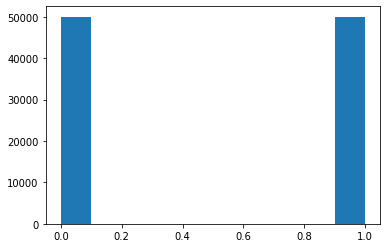

In [4]:
plt.hist(y_train)
plt.show()

In [5]:
x_train = []
for i in X:
  x_train.append(i[0])
x_train = np.array(x_train)
print(x_train.shape)

(100000, 4)


In [6]:
!pip install dgl-cu101
import dgl
import torch
import networkx as nx

Using backend: pytorch


## Approach
I am choosing the following two graph-based architectures:
1. Node Classification
2. Graph Classification 

### Node Classification
In this approach, I will encode the data as nodes of a graph and then train a GNN to learn to classify these nodes. In this way we can build a classifier which classifies quarks from gluons.

### Graph Classification
In this approach, I will encode each training sample as a graph, resulting in a training data of different graphs. I will then train a GNN to learn to classify different graphs. In this way too we can build a classifier which classifies quarks from gluons.

### Node Classification
Let us begin by preparing the dataset. We will use a small subset of the training data for demonstration.

In [47]:
x_train_small = x_train[:2000].astype(np.float32)
y_train_small = y_train[:2000]
class NodeClassificationDataset(dgl.data.DGLDataset):
  """A Class to process and convert the numpy training data into Graphs so that it can be used in GNNs"""
  def __init__(self):
    super().__init__(name='node_classification')
    self.num_classes = 2
  
  def process(self):
    node_features = torch.from_numpy(x_train_small)
    node_labels = torch.from_numpy(y_train_small).long()

    self.graph = dgl.from_networkx(nx.generators.fast_gnp_random_graph(x_train_small.shape[0], 0.008, seed=1337))
    self.graph.ndata['feat'] = node_features
    self.graph.ndata['label'] = node_labels
    # self.graph.ndata['weight'] = None

    n_nodes = x_train_small.shape[0]
    n_train = int(n_nodes * 0.8)
    n_val = int(n_nodes * 0.1)
    train_mask = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask = torch.zeros(n_nodes, dtype=torch.bool)
    train_mask[:n_train] = True
    val_mask[n_train:n_train+n_val] = True
    test_mask[n_train+n_val:] = True
    self.graph.ndata['train_mask'] = train_mask
    self.graph.ndata['val_mask'] = val_mask
    self.graph.ndata['test_mask'] = test_mask
  
  def __getitem__(self, idx):
    return self.graph
  
  def __len__(self):
    return 1

node_classif_dataset = NodeClassificationDataset()
node_classif_graph = node_classif_dataset[0]

print(node_classif_graph)

Graph(num_nodes=2000, num_edges=31988,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


### Defining the Model

In [48]:
from dgl.nn import GraphConv

class NodeClassificationModel(torch.nn.Module):
  """A Model Class having the methods to implement and forward pass a GNN."""
  def __init__(self, in_feats, num_classes):
    super(NodeClassificationModel, self).__init__()
    self.conv1 = GraphConv(in_feats, 16)
    self.conv2 = GraphConv(16, 32)
    self.conv3 = GraphConv(32, 64)
    self.conv4 = GraphConv(64, num_classes)
  
  def forward(self, g, in_feat):
    h = self.conv1(g, in_feat)
    h = torch.nn.functional.elu(h)
    h = self.conv2(g, h)
    h = torch.nn.functional.relu(h)
    h = self.conv3(g, h)
    h = torch.nn.functional.relu(h)
    h = self.conv4(g, h)
    return h

node_classif_model = NodeClassificationModel(node_classif_graph.ndata['feat'].shape[1], node_classif_dataset.num_classes)

### Defining the Training Loop

In [49]:
def train(g, model, num_epochs):
  """The function implementing the main train loop."""
  losses = []
  accs = {'train':[], 'val': [], 'test': []}
  optimizer = torch.optim.Adam(model.parameters(), lr=1*1e-5, betas=(0.6, 0.7))
  best_val_acc = 0.0
  best_test_acc = 0.0

  features = g.ndata['feat']
  labels = g.ndata['label']
  train_mask = g.ndata['train_mask']
  val_mask = g.ndata['val_mask']
  test_mask = g.ndata['test_mask']

  for e in range(num_epochs):
    model.train()
    logits = model(g, features)
    preds = logits.argmax(1)

    loss = torch.nn.functional.cross_entropy(logits[train_mask], labels[train_mask])

    train_acc = (preds[train_mask] == labels[train_mask]).float().mean()
    val_acc = (preds[val_mask] == labels[val_mask]).float().mean()
    test_acc = (preds[test_mask] == labels[test_mask]).float().mean()
    losses.append(loss)
    accs['train'].append(train_acc)
    accs['val'].append(val_acc)
    accs['test'].append(test_acc)

    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc
    
    with torch.no_grad():
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if e % 5 == 0:
      print('In epoch {}, loss: {:.8f}, val acc: {:.8f} (best {:.8f}), test acc: {:.8f} (best {:.8f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
  
  return losses, accs

In [50]:
node_classif_graph = node_classif_graph.to('cuda')
node_classif_model = node_classif_model.to('cuda')
node_classif_losses, node_classif_accs = train(node_classif_graph, node_classif_model, 5000)

In epoch 0, loss: 7.58675766, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 5, loss: 7.52613258, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 10, loss: 7.46548605, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 15, loss: 7.40483522, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 20, loss: 7.34418201, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 25, loss: 7.28349257, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 30, loss: 7.22277641, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 35, loss: 7.16203165, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 40, loss: 7.10127878, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 45, loss: 7.

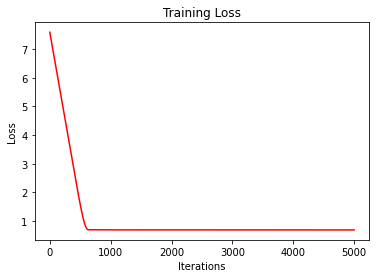

In [51]:
plt.plot(node_classif_losses, 'r-')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

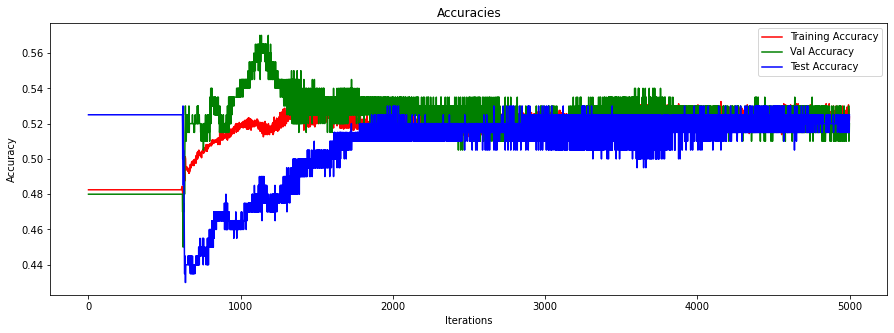

In [52]:
plt.figure(figsize=(15, 5))
plt.plot(node_classif_accs['train'], 'r-', label='Training Accuracy')
plt.plot(node_classif_accs['val'], 'g-', label='Val Accuracy')
plt.plot(node_classif_accs['test'], 'b-', label='Test Accuracy')
plt.title('Accuracies')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
logits = node_classif_model(node_classif_graph, node_classif_graph.ndata['feat'])
pred = logits.argmax(1)
pred

tensor([1, 0, 0,  ..., 1, 1, 1], device='cuda:0')

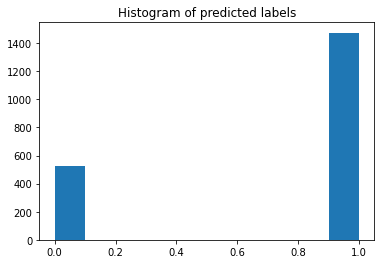

In [54]:
plt.hist(pred.cpu().numpy())
plt.title("Histogram of predicted labels")
plt.show()

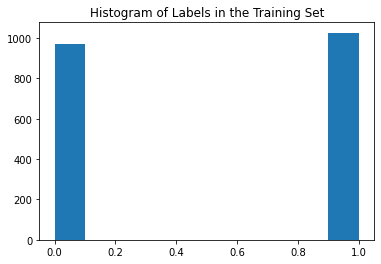

In [55]:
label = node_classif_graph.ndata['label']
plt.hist(label.cpu().numpy())
plt.title("Histogram of Labels in the Training Set")
plt.show()

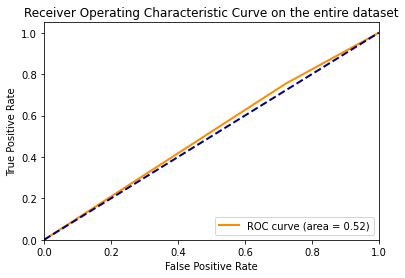

In [56]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(label.cpu().numpy(), pred.cpu().numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve on the entire dataset')
plt.legend(loc="lower right")
plt.show()

## Graph Classification 
We now begin with this approach. Like before, we begin with creating a dataloader. We will fix the number of nodes in each graph (a tunable parameter) and then generate random graphs for each point in the dataset. We will give a label for each such graph.   
In this approach, we can take the entire dataset provided as we can load the graphs in batches while training. But for the sake of fair comparison, we will take the same smaller dataset that we used for the Node Classification Approach.

In [17]:
x_train_small[0].shape

(4,)

In [18]:
class GraphClassificationDataset(dgl.data.DGLDataset):
  """A Class to process and convert the numpy training data into Graphs so that it can be used in GNNs."""
  def __init__(self):
    super().__init__(name='graph_classification') 
    self.num_classes = 2
    self.dim_nfeats = 4
  
  def process(self):
    self.graphs = []
    self.labels = []
    num_examples = len(x_train_small)
    num_train = int(num_examples * 0.8)
    num_val = int(num_examples * 0.1)
    train_mask = torch.zeros(num_examples, dtype=torch.bool)
    val_mask = torch.zeros(num_examples, dtype=torch.bool)
    test_mask = torch.zeros(num_examples, dtype=torch.bool)
    train_mask[:num_train] = True
    val_mask[num_train:num_train+num_val] = True
    test_mask[num_train+num_val:] = True
    self.train_mask = train_mask
    self.test_mask = test_mask
    self.val_mask = val_mask 

    for id in range(len(x_train_small)):
      g = dgl.from_networkx(nx.generators.fast_gnp_random_graph(20, p=0.6))
      g.ndata['feat'] = torch.from_numpy(np.repeat(x_train_small[id].reshape(1,4),20,0))
      g.ndata['label'] = torch.LongTensor([y_train_small[id]]*20)
      self.graphs.append(g)
      self.labels.append(y_train_small[id])
    
    self.labels = torch.LongTensor(self.labels)

  def __getitem__(self, idx):
    return self.graphs[idx], self.labels[idx]

  def __len__(self):
    return len(self.graphs)

In [19]:
graph_classif_dataset = GraphClassificationDataset()
g_sample, label_sample = graph_classif_dataset[0]
print(g_sample, label_sample) 

Graph(num_nodes=20, num_edges=234,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}) tensor(1)


We will now create a dataloader

In [20]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(graph_classif_dataset)
num_train = int(num_examples * 0.8)
num_val = int(num_examples * 0.1)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_train+num_val))
test_sampler = SubsetRandomSampler(torch.arange(num_train+num_val, num_examples))

train_dataloader = GraphDataLoader(graph_classif_dataset, sampler=train_sampler, batch_size=5, drop_last=False)
val_dataloader = GraphDataLoader(graph_classif_dataset, sampler=val_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(graph_classif_dataset, sampler=test_sampler, batch_size=5, drop_last=False)

In [21]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=100, num_edges=1132,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), tensor([1, 1, 1, 0, 1])]


In [22]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([20, 20, 20, 20, 20])
Number of edges for each graph element in the batch: tensor([228, 234, 218, 220, 232])
The original graphs in the minibatch:
[Graph(num_nodes=20, num_edges=228,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=234,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=218,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=220,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=232,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype

### Defining the Model

In [23]:
from dgl.nn import GraphConv

class GraphClassificationModel(torch.nn.Module):
  """A Model Class having the methods to implement and forward pass a GNN."""
  def __init__(self, in_feats, num_classes):
    super(GraphClassificationModel, self).__init__()
    self.conv1 = GraphConv(in_feats, 16)
    self.conv2 = GraphConv(16, 32)
    self.conv3 = GraphConv(32, num_classes)
    # self.conv3 = GraphConv(32, 64)
    # self.conv4 = GraphConv(64, num_classes)

  def forward(self, g, in_feat):
    h = self.conv1(g, in_feat)
    h = torch.nn.functional.relu(h)
    h = self.conv2(g, h)
    h = torch.nn.functional.relu(h)
    h = self.conv3(g, h)
    # h = torch.nn.functional.relu(h)
    # h = self.conv4(g, h)
    g.ndata['h'] = h
    return dgl.mean_nodes(g, 'h')

In [24]:
graph_classif_model = GraphClassificationModel(graph_classif_dataset.dim_nfeats, graph_classif_dataset.num_classes)

### Defining the Training Loop

In [25]:
def train(train_loader, val_loader, test_loader, model, num_epochs):
  """The function implementing the main train loop."""
  losses = []
  accs = {'train':[], 'val': [], 'test': []}
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.9999))
  best_val_acc = 0.0
  best_test_acc = 0.0

  for e in range(num_epochs):
    train_acc_batch = []
    val_acc_batch = []
    test_acc_batch = []
    train_loss_batch = []
    for batched_graph, labels in train_loader:
      model.train()
      batched_graph, labels = batched_graph.to('cuda'), labels.to('cuda')
      logits = model(batched_graph, batched_graph.ndata['feat'].float())
      pred = logits.argmax(1)
      loss = torch.nn.functional.cross_entropy(logits, labels)
      train_loss_batch.append(loss)
      train_acc = (pred == labels).float().mean()
      train_acc_batch.append(train_acc)
      with torch.no_grad():  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accs['train'].append(sum(train_acc_batch) / len(train_acc_batch))
    losses.append(sum(train_loss_batch) / len(train_loss_batch))

    model.eval()
    for batched_graph_val, labels_val in val_loader:
      batched_graph_val, labels_val = batched_graph_val.to('cuda'), labels_val.to('cuda')
      logits_val = model(batched_graph_val, batched_graph_val.ndata['feat'].float())
      pred_val = logits_val.argmax(1)
      val_acc = (pred_val == labels_val).float().mean()
      val_acc_batch.append(val_acc)
    accs['val'].append(sum(val_acc_batch) / len(val_acc_batch))

    for batched_graph_test, labels_test in test_loader:
      batched_graph_test, labels_test = batched_graph_test.to('cuda'), labels_test.to('cuda')
      logits_test = model(batched_graph_test, batched_graph_test.ndata['feat'].float())
      pred_test = logits_test.argmax(1)
      test_acc = (pred_test == labels_test).float().mean()
      test_acc_batch.append(test_acc)
    accs['test'].append(sum(test_acc_batch) / len(test_acc_batch))

    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc

    if e % 5 == 0:
      print('In epoch {}, loss: {:.8f}, val acc: {:.8f} (best {:.8f}), test acc: {:.8f} (best {:.8f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
  
  return losses, accs

In [26]:
graph_classif_model = graph_classif_model.to('cuda')
graph_classif_losses, graph_classif_accs = train(train_dataloader, val_dataloader, test_dataloader, graph_classif_model, 700)

In epoch 0, loss: 1.32255912, val acc: 0.80000001 (best 0.80000001), test acc: 0.80000001 (best 0.80000001)
In epoch 5, loss: 0.71140397, val acc: 0.80000001 (best 0.80000001), test acc: 0.20000000 (best 0.80000001)
In epoch 10, loss: 0.69860405, val acc: 0.40000001 (best 0.80000001), test acc: 0.60000002 (best 0.80000001)
In epoch 15, loss: 0.65682209, val acc: 0.60000002 (best 0.80000001), test acc: 0.80000001 (best 0.80000001)
In epoch 20, loss: 0.69134969, val acc: 0.60000002 (best 0.80000001), test acc: 0.20000000 (best 0.80000001)
In epoch 25, loss: 0.68840706, val acc: 0.40000001 (best 1.00000000), test acc: 0.40000001 (best 0.60000002)
In epoch 30, loss: 0.64081395, val acc: 0.80000001 (best 1.00000000), test acc: 0.60000002 (best 0.60000002)
In epoch 35, loss: 0.68934125, val acc: 0.40000001 (best 1.00000000), test acc: 0.40000001 (best 0.60000002)
In epoch 40, loss: 0.65559149, val acc: 0.60000002 (best 1.00000000), test acc: 0.40000001 (best 0.60000002)
In epoch 45, loss: 0.

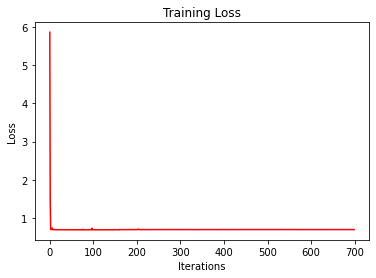

In [33]:
plt.plot(graph_classif_losses, 'r-')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

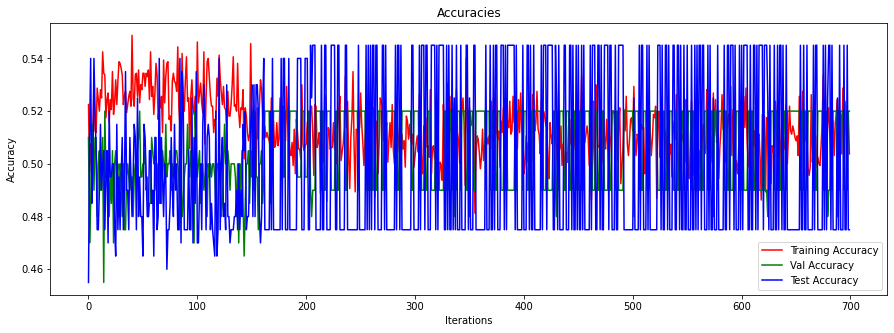

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(graph_classif_accs['train'], 'r-', label='Training Accuracy')
plt.plot(graph_classif_accs['val'], 'g-', label='Val Accuracy')
plt.plot(graph_classif_accs['test'], 'b-', label='Test Accuracy')
plt.title('Accuracies')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
all_preds_graph_classif = []
for batched_graph_test, labels_test in test_dataloader:
    batched_graph_test = batched_graph_test.to('cuda')
    labels_test = labels_test.to('cuda')
    logits_test = graph_classif_model(batched_graph_test, batched_graph_test.ndata['feat'].float())
    pred_test = logits_test.argmax(1)
    all_preds_graph_classif = all_preds_graph_classif + [*pred_test.cpu().numpy()]

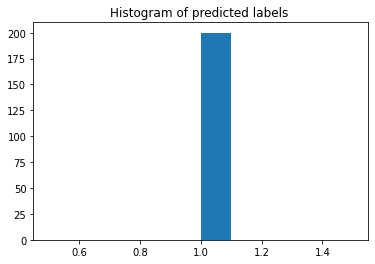

In [35]:
plt.hist(all_preds_graph_classif)
plt.title("Histogram of predicted labels ")
plt.show()

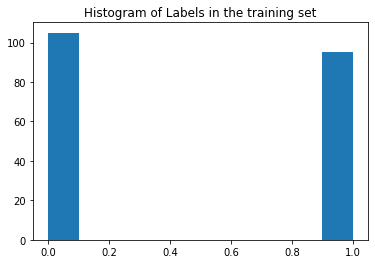

In [34]:
label = graph_classif_dataset.labels[graph_classif_dataset.test_mask]
plt.hist(label.cpu().numpy())
plt.title("Histogram of Labels in the training set")
plt.show()

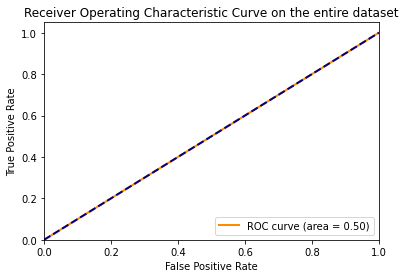

In [32]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(label.cpu().numpy(), all_preds_graph_classif)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve on the entire dataset')
plt.legend(loc="lower right")
plt.show()

## Comparison
As we can see above, theoritically both the architectures will work. The loss vs iteration curve and the ROC suggest that the graph classification approcach has failed to learn and it is preidicting the same output for all inputs. The main reason for this result is that:  
1. I used very less training data
2. The training data has very less number of features.
3. The limited computational resource. The colab notebook's RAM was getting used up even before training for 1000 epochs. As we can see in the Node Classification approach, the GNN required atleast a 1000 epochs to stabilize.  

Because of the above reasons, I think the Graph Classification approach gave inferior performance.

### Possible Improvements
- Neural Message Passing Models have shown good results on other particle jet classification tasks like [here](https://dl4physicalsciences.github.io/files/nips_dlps_2017_29.pdf). 
- Studying and applying better ways of encoding the train data in the form of graphs